# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/Ask_Politics_comments.zst"
file_submissions = "../../../../data/reddit/Ask_Politics_submissions.zst"

subreddit_here = "Ask_Politics"
subreddit = "Ask_Politics"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [6]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [7]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [8]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [9]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 47176


In [10]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 532593


In [11]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 180846
Nr. of replies 98737


### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [10]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


4.448746648298934


,submission_id,count
0,1003vi8,1
1,100k9js,1
2,100quyc,4
3,101vyr4,11
4,102cs5e,1
...,...,...
40646,zxvksa,10
40647,zyo35t,5
40648,zzcmnz,1
40649,zzd50l,2


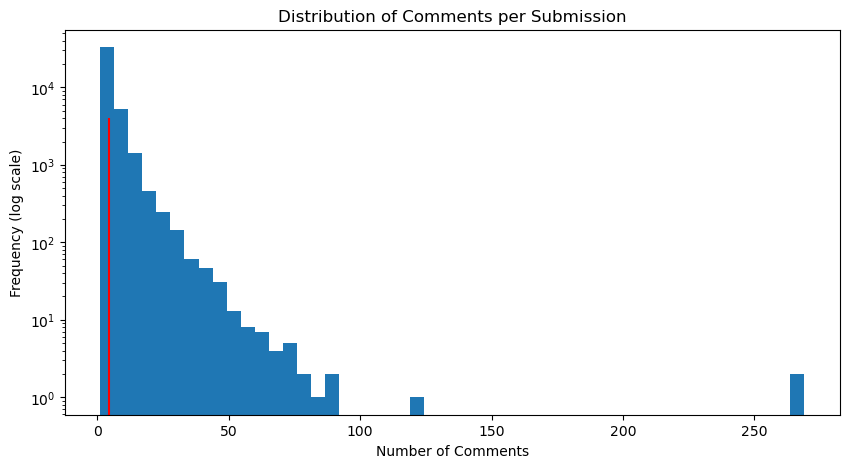

In [11]:
# Histogram
plt.figure(figsize=(10, 5))
plt.hist(relevant_submissions['count'], bins=50)
plt.vlines((relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4000)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Number of Comments")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Comments per Submission")
plt.show()


In [12]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,10725,0.000000,4.030397
1,2,6616,0.301030,3.820595
2,3,5556,0.477121,3.744762
3,4,4414,0.602060,3.644832
4,5,3324,0.698970,3.521661
...,...,...,...,...
72,85,1,1.929419,0.000000
73,87,2,1.939519,0.301030
74,123,1,2.089905,0.000000
75,266,1,2.424882,0.000000


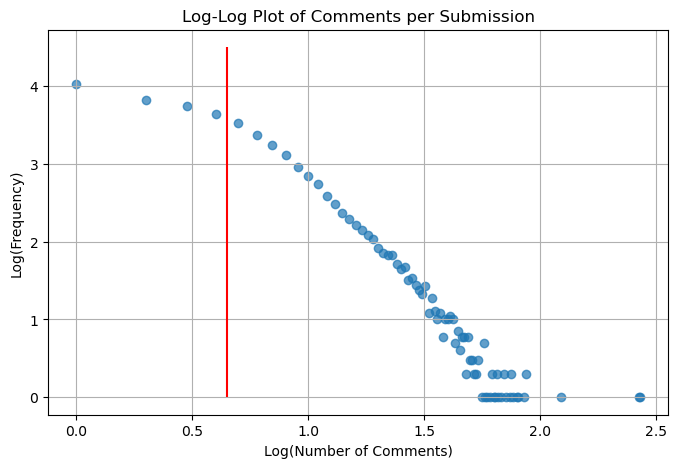

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nr. of submissions')

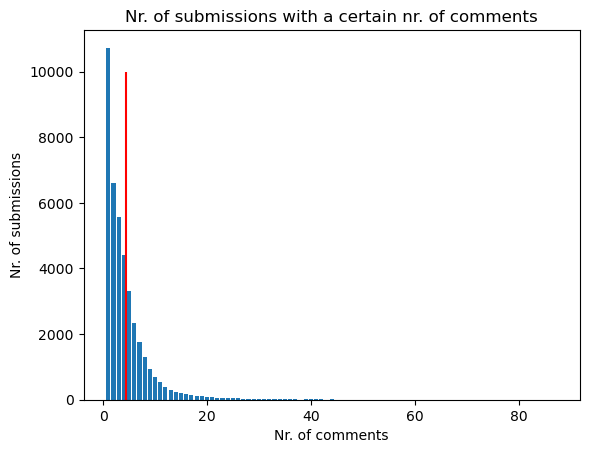

In [ ]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['comment_count'], height = plt_data['class_count'])
plt.vlines(relevant_submissions['count'].mean(), colors="red", ymin = 0, ymax=10000)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

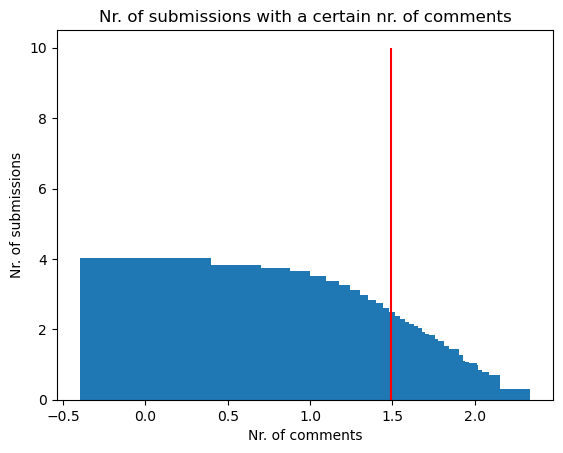

In [ ]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['log_com_count'], height = plt_data['log_class_count'])
plt.vlines(np.log(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=10)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [12]:
# select relevant submissions (non-empty and those, I have comments for)
relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 4.448746648298934
Nr. of submission, that I have comments for 40651
All submissions found
Removing empty submissions deleted 16574 submissions
Kept 24077 submissions
Nr. of comments, whose submission is retaied 128049
Share 0.7080554726120567


In [13]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

# can keep roughly half of my submissions

Number of relevant submissions: 24077
Lost submissions:  23099


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.355164e+09,14m325,2t160,[deleted],14m325,c7ebuf4,c7ebuf4,-1.0,-1,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
1,Ramblin_Dash,1.355166e+09,14m325,2t160,Regarding Perry vs. Brown (the current name of...,14m325,c7ecp8d,c7ecp8d,7.0,7,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
2,TehNoff,1.355170e+09,14m26x,2t160,So what was wrong with /r/PoliticalDiscussion ...,14m26x,c7edr13,c7edr13,5.0,5,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
3,IBiteYou,1.355171e+09,14m26x,2t160,&gt;We will be adhering to the AskScience styl...,14m26x,c7ee45j,c7ee45j,3.0,3,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
4,[deleted],1.355171e+09,14m18a,2t160,[deleted],14m18a,c7eecqr,c7eecqr,1.0,1,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128044,Much_Cellist8763,1.703372e+09,mh702s,2t160,As soon as we were taken off the gold standard...,mh702s,keo5f9w,keo5f9w,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-23,comment
128045,Extension_Buy_3734,1.703435e+09,xownab,2t160,Except for provider (doctors) who deal in cash...,xownab,ker63l6,ker63l6,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-24,comment
128046,nearmyst,1.703623e+09,14l0zf4,2t160,Biden was the worst candidate on the democrati...,14l0zf4,kf13how,kf13how,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-26,comment
128047,[deleted],1.703741e+09,167034x,2t160,[removed],167034x,kf8a3gp,kf8a3gp,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-28,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [15]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 72018
Nr. of unique comments 47448
Nr. of unique submissions 18804


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7ebuf4,c7ecmy1,"Well, here's the first comment of this subredd...",Ask_Politics,1.355166e+09,zoolander951,5.0,5,0.0,14m325,...,[deleted],-1.0,-1,0.0,1.355164e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
1,c7ecp8d,c7ecs2n,&gt; Ted Olson and David Boies are extremely g...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
2,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
3,c7edr13,c7edsp8,"/r/Politicaldiscussion is too broad, and the c...",Ask_Politics,1.355170e+09,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
4,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72013,esnrw5z,kcyitc6,Me too.,Ask_Politics,1.702334e+09,Header1967,1.0,1,0.0,c8e98b,...,subsidiarity,NaN,1,NaN,1.562147e+09,\n\nI like having a decent political conversat...,chillermane,NaN,23,1.562098e+09
72014,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,1.702416e+09,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,1.688412e+09,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,1.688317e+09
72015,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,1.702431e+09,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,1.550918e+09,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,1.550913e+09
72016,jl96sn2,kd5a9km,Big-brained user.,Ask_Politics,1.702447e+09,ClementAcrimony,1.0,1,0.0,pqykv0,...,timothycrawford369,1.0,1,0.0,1.684819e+09,After researching it seems like White Southern...,shivlad02,NaN,51,1.632014e+09


In [16]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [18]:
df_matched['body_child'].value_counts().head(10)

df_matched['body_parent'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*
# I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

# don't filter based on frequency of a text
# short replies (like thank you), will be removed with len < 5
# frequent comments can just be active comments
# bots are removed by author = [removed]


body_parent
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [19]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 8593 interactions. Share:  0.11931739287400372
Kept 63425 interactions.
Deleting empty authors deleted 5832 interactions. Share:  0.09195112337406386
Kept 57593 interactions.
Length 5 removes 3205 interactions
Kept 54388 interactions
Drop duplicates (in parent & child text and author) removed 0 interactions. Share:  0.0
Kept 54388 interactions.
After text cleaning 124 interactions had empty texts and got removed. Share:  0.002279914687063323
Kept 54264 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
2,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,1.355170e+09,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
3,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
4,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,1.355171e+09,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54259,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,1.701905e+09,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,1.552664e+09,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,1.552662e+09
54260,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,1.702175e+09,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,1.580156e+09,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,1.580084e+09
54261,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,1.702416e+09,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,1.688412e+09,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,1.688317e+09
54262,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,1.702431e+09,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,1.550918e+09,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,1.550913e+09


In [22]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Save and export

In [20]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
2,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,1.355170e+09,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
3,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
4,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,1.355171e+09,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54259,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,1.701905e+09,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,1.552664e+09,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,1.552662e+09
54260,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,1.702175e+09,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,1.580156e+09,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,1.580084e+09
54261,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,1.702416e+09,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,1.688412e+09,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,1.688317e+09
54262,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,1.702431e+09,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,1.550918e+09,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,1.550913e+09


***
## **Descriptive Stats**

In [21]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

63102
Unique Users:  51209


### Time Stats and originally pulled counts

In [22]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2012-12-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 47176
Number of comments and replies: 532593
---------------------------------------------



### Descriptive Stats after Matching

In [23]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  72018
Number of unique comments:  47448
Number of unique submissions:  18804


### Descriptive Stats after cleaning for high quality texts

In [24]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  54264
Unique Comments:  37493
Unique Submissions:  16477


In [25]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  24430
